# TESS Atlas fit for TOI 116

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 116.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-116.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-116.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-116.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 116

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 116 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

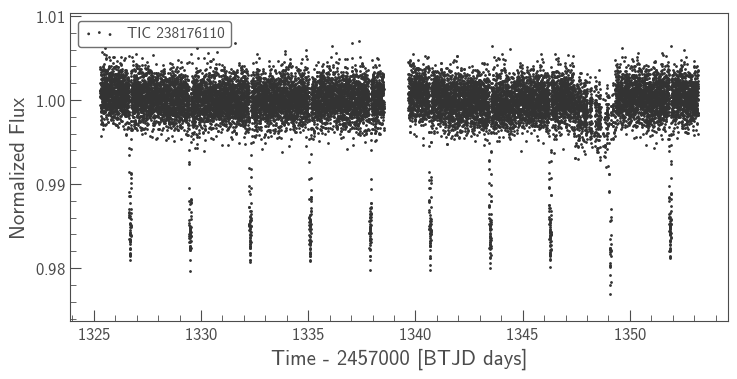

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -47278.12800727575 -> -47228.75208261569


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -36718.123754519576 -> -36211.92351503804


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -36211.92351503804 -> -35708.01402864568


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -35708.01402864568 -> -35707.95420872379


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -35707.95420872379 -> -35707.79536676191


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -35707.79536676191 -> -35707.733294737736


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -35707.733294737736 -> -35673.4763832617


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -35673.4763832617 -> -35673.47638326155


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -35673.47638326155 -> -35673.47638326155


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -35673.47638326155 -> -35673.47638326147


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -35673.47638326147 -> -35673.47638326147


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -35673.47638326147 -> -35673.47638326147


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -35673.47638326147 -> -35673.47638326147


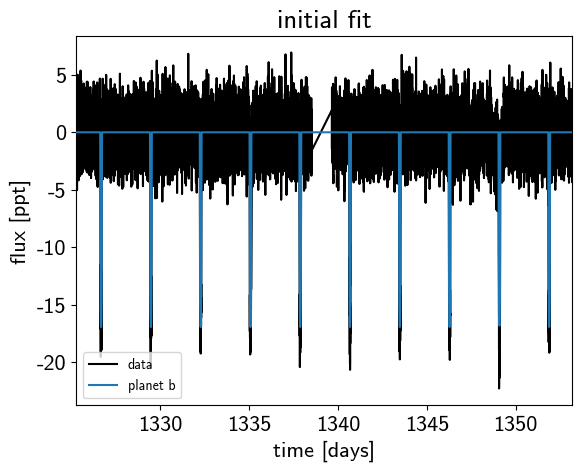

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:05, 17.70draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:11,  7.93draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:15,  5.81draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:01<00:14,  5.87draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:23,  3.67draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:02<00:23,  3.71draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:26,  3.15draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:21,  3.94draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:28,  2.94draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:03<00:22,  3.67draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:26,  3.02draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:21,  3.65draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:26,  3.03draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:24,  3.09draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:23,  3.19draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:22,  3.32draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:06<00:17,  4.14draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:24,  2.91draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:07<00:22,  3.04draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:08<00:21,  3.18draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:19,  3.27draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:09<00:18,  3.41draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:18,  3.38draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:10<00:17,  3.39draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:16,  3.45draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:11<00:15,  3.53draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:14,  3.78draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:12<00:15,  3.47draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:12<00:14,  3.63draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:13<00:14,  3.59draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:13<00:13,  3.65draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:13<00:13,  3.59draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:13<00:12,  3.70draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:14<00:12,  3.66draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:14<00:12,  3.81draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:14<00:12,  3.69draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:14<00:11,  3.87draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:15<00:11,  3.71draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:15<00:10,  3.93draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:15<00:11,  3.69draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:15<00:10,  3.72draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:16<00:10,  3.71draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:16<00:09,  3.82draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:16<00:09,  3.72draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:16<00:09,  3.90draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:17<00:09,  3.72draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:17<00:08,  3.95draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:17<00:08,  3.72draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:18<00:08,  3.93draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:18<00:08,  3.71draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:18<00:06,  4.47draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:18<00:07,  3.68draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:19<00:06,  3.89draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:19<00:07,  3.60draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:19<00:06,  3.98draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:20<00:06,  3.59draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:20<00:05,  3.97draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:20<00:06,  3.37draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:20<00:05,  3.94draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:21<00:06,  2.98draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:21<00:05,  3.15draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:22<00:04,  3.29draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:22<00:04,  3.34draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:23<00:03,  3.58draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:23<00:03,  3.49draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:23<00:03,  3.20draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:24<00:02,  3.57draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:24<00:03,  2.75draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:25<00:02,  2.96draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:25<00:01,  3.16draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:26<00:00,  3.32draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:28<00:00,  1.89draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:28<00:00,  3.65draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:05, 17.08draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:11,  8.21draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:01<00:15,  5.89draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:01<00:13,  6.72draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:22,  3.81draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:02<00:23,  3.65draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:19,  4.34draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:03<00:25,  3.28draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:03<00:20,  4.05draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:04<00:19,  4.19draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:04<00:19,  4.08draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:04<00:20,  3.81draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:21,  3.50draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:05<00:22,  3.38draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:05<00:18,  4.10draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:06<00:22,  3.26draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:06<00:21,  3.25draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:06<00:16,  4.14draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:07<00:19,  3.56draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:07<00:16,  3.97draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:07<00:22,  2.98draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:08<00:20,  3.13draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:09<00:19,  3.22draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:09<00:18,  3.29draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:10<00:17,  3.34draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:10<00:16,  3.35draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:11<00:14,  3.71draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:11<00:13,  3.68draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:12<00:11,  4.29draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:12<00:14,  3.37draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:12<00:12,  3.98draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:13<00:13,  3.43draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:13<00:11,  3.93draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:13<00:10,  4.26draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:13<00:09,  4.65draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:14<00:11,  3.65draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:14<00:09,  4.27draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:14<00:11,  3.58draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:14<00:09,  4.19draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:15<00:10,  3.54draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:15<00:07,  4.51draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:15<00:09,  3.67draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:15<00:07,  4.30draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:16<00:09,  3.59draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:16<00:07,  4.18draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:16<00:08,  3.45draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:17<00:07,  4.06draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:17<00:09,  3.15draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:18<00:08,  3.23draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:18<00:07,  3.29draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:19<00:06,  3.39draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:19<00:06,  3.49draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:20<00:05,  3.51draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:20<00:04,  3.95draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:21<00:02,  4.99draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:21<00:03,  3.87draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:21<00:02,  4.28draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:21<00:02,  3.72draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:22<00:01,  4.51draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:22<00:02,  3.91draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:22<00:01,  4.13draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:23<00:01,  4.56draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:23<00:00,  4.30draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:23<00:00,  3.79draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:23<00:00,  3.97draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:25<00:00,  1.28draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:26<00:00,  1.61draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:58,  1.72draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<01:30,  2.23draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:18,  2.55draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<01:09,  2.83draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:02<00:59,  3.29draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:02<01:01,  3.19draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:49,  3.88draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:02<00:52,  3.68draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:03<00:52,  3.67draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:03<00:43,  4.34draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:03<00:37,  5.06draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:03<00:49,  3.82draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:04<00:40,  4.60draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:04<00:50,  3.65draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:04<00:41,  4.44draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:04<00:51,  3.56draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:05<00:42,  4.34draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:05<00:36,  4.99draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:05<00:28,  6.36draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:05<00:45,  3.89draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:06<00:45,  3.85draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:06<00:46,  3.74draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:07<00:39,  4.42draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:07<00:49,  3.51draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:08<00:51,  3.35draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:08<00:39,  4.28draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:08<00:35,  4.78draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:08<00:33,  4.89draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:08<00:31,  5.28draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:09<00:40,  4.08draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:09<00:35,  4.64draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:09<00:30,  5.38draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:10<00:40,  3.96draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:10<00:34,  4.69draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:10<00:30,  5.22draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:10<00:28,  5.60draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:10<00:30,  5.08draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:10<00:35,  4.45draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:11<00:35,  4.36draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:11<00:30,  5.00draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:11<00:34,  4.44draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:11<00:34,  4.35draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:12<00:37,  4.02draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:12<00:37,  3.94draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:12<00:38,  3.81draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:13<00:39,  3.68draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:13<00:40,  3.63draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:13<00:40,  3.62draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:14<00:42,  3.43draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:14<00:40,  3.50draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:14<00:32,  4.35draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:15<00:34,  4.02draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:15<00:35,  3.85draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:15<00:26,  5.14draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:16<00:29,  4.52draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:16<00:32,  4.09draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:17<00:29,  4.38draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:17<00:23,  5.45draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:17<00:26,  4.75draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:17<00:23,  5.38draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:18<00:32,  3.86draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:18<00:27,  4.51draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:18<00:35,  3.45draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:18<00:29,  4.13draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:19<00:26,  4.50draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:19<00:28,  4.19draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:20<00:25,  4.50draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:20<00:25,  4.51draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:20<00:26,  4.22draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:21<00:27,  4.08draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:21<00:27,  3.90draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:22<00:27,  3.82draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:22<00:21,  4.79draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:23<00:25,  4.02draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:23<00:25,  4.05draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:23<00:25,  3.91draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:24<00:32,  3.11draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:24<00:27,  3.59draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:24<00:23,  4.11draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:25<00:23,  3.95draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:25<00:19,  4.77draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:25<00:25,  3.61draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:26<00:23,  3.95draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:26<00:21,  4.14draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:26<00:19,  4.50draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:26<00:23,  3.71draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:26<00:20,  4.21draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:27<00:28,  3.04draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:27<00:21,  3.85draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:28<00:24,  3.44draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:28<00:21,  3.80draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:28<00:18,  4.37draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:29<00:18,  4.23draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:29<00:20,  3.79draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:29<00:19,  3.85draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:29<00:22,  3.40draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:30<00:19,  3.77draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:30<00:21,  3.40draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:30<00:18,  3.82draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:30<00:14,  4.91draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:31<00:12,  5.48draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:31<00:11,  5.84draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:31<00:11,  5.58draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:31<00:11,  5.69draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:32<00:13,  4.74draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:32<00:13,  4.44draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:32<00:14,  4.13draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:32<00:14,  4.04draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:33<00:17,  3.32draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:33<00:14,  3.97draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:33<00:17,  3.21draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:34<00:13,  4.00draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:34<00:11,  4.79draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:34<00:12,  4.18draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:34<00:10,  4.91draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:34<00:10,  4.84draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:35<00:11,  4.37draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:35<00:09,  5.10draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:35<00:12,  3.74draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:36<00:10,  4.48draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:36<00:13,  3.47draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:36<00:10,  4.19draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:36<00:09,  4.44draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:37<00:10,  4.30draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:37<00:10,  3.93draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:37<00:10,  3.94draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [00:37<00:10,  3.70draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:38<00:11,  3.42draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:38<00:09,  3.90draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:38<00:08,  4.36draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:39<00:07,  4.33draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:39<00:06,  4.82draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:40<00:06,  4.41draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:40<00:05,  5.16draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:40<00:05,  4.82draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:41<00:05,  4.37draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:41<00:04,  4.65draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:42<00:04,  4.64draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:42<00:03,  4.83draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:42<00:03,  4.80draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:42<00:04,  3.97draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:43<00:03,  3.81draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:43<00:02,  4.65draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:43<00:02,  4.94draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:44<00:02,  4.83draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:44<00:01,  5.11draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:44<00:01,  5.12draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:44<00:01,  5.05draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:45<00:00,  5.45draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:45<00:01,  3.50draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:45<00:00,  3.59draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:46<00:00,  3.19draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:46<00:00,  3.86draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:46<00:00,  3.11draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/404 [00:00<00:10, 38.65draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:09, 41.01draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:00<00:08, 47.35draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:00<00:07, 52.16draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:00<00:06, 60.52draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:00<00:05, 62.89draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:00<00:06, 54.75draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:00<00:06, 56.18draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:01<00:05, 59.61draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:01<00:05, 59.78draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:01<00:05, 58.59draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:01<00:05, 60.90draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:01<00:04, 64.64draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:01<00:06, 46.94draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:01<00:06, 48.94draws/s]

Sampling 2 chains:  28%|██▊       | 112/404 [00:01<00:05, 53.68draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:02<00:04, 57.33draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:02<00:05, 55.01draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:02<00:04, 56.06draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:02<00:05, 50.92draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:02<00:04, 53.34draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:02<00:04, 57.32draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:02<00:04, 57.87draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:02<00:04, 50.92draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:03<00:04, 48.96draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:03<00:04, 50.43draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:03<00:04, 46.17draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:03<00:05, 42.85draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:03<00:04, 44.02draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [00:03<00:04, 49.41draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:03<00:03, 49.93draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:03<00:04, 41.65draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:04<00:04, 40.31draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:04<00:04, 44.57draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:04<00:03, 49.82draws/s]

Sampling 2 chains:  59%|█████▊    | 237/404 [00:04<00:03, 50.23draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:04<00:03, 50.13draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [00:04<00:02, 53.37draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:04<00:02, 55.21draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [00:04<00:02, 51.75draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:05<00:02, 52.69draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:05<00:02, 56.88draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:05<00:01, 62.10draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:05<00:01, 66.39draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:05<00:01, 61.57draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:05<00:01, 51.11draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:05<00:01, 52.49draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:05<00:01, 46.98draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [00:06<00:02, 35.06draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:06<00:01, 38.39draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [00:06<00:01, 41.17draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:06<00:01, 38.39draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [00:06<00:02, 28.53draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [00:06<00:01, 28.94draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [00:07<00:01, 30.34draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [00:07<00:01, 35.52draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:07<00:01, 37.36draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:07<00:01, 34.40draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:07<00:00, 31.66draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:07<00:00, 31.10draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:07<00:00, 33.27draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:08<00:00, 33.55draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:08<00:00, 35.19draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [00:08<00:00, 30.85draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:08<00:00, 34.77draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:08<00:00, 34.63draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:08<00:00, 47.22draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:27, 28.71draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:23, 33.78draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:24, 31.71draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:00<00:21, 35.98draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:00<00:20, 37.99draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:00<00:24, 32.10draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:00<00:22, 34.07draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:01<00:23, 33.17draws/s]

Sampling 2 chains:   5%|▌         | 41/804 [00:01<00:40, 18.80draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:01<00:37, 20.19draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:01<00:35, 21.41draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:01<00:30, 24.35draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:01<00:29, 25.62draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:02<00:26, 28.59draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:02<00:25, 29.63draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:02<00:21, 34.00draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:02<00:17, 40.60draws/s]

Sampling 2 chains:  10%|█         | 82/804 [00:02<00:18, 38.62draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:02<00:16, 44.56draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:02<00:17, 40.99draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:02<00:15, 44.83draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:03<00:14, 46.53draws/s]

Sampling 2 chains:  14%|█▍        | 114/804 [00:03<00:15, 44.13draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:03<00:16, 42.22draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:03<00:18, 37.60draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:03<00:16, 40.39draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:03<00:15, 44.30draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:03<00:15, 44.08draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:03<00:14, 44.98draws/s]

Sampling 2 chains:  19%|█▉        | 153/804 [00:04<00:13, 48.56draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:04<00:12, 50.99draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:04<00:11, 53.74draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [00:04<00:11, 54.42draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:04<00:12, 49.83draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:04<00:12, 51.26draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:04<00:14, 42.95draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:04<00:13, 45.89draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:05<00:13, 45.58draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:05<00:12, 47.70draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [00:05<00:10, 55.38draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:05<00:09, 60.94draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [00:05<00:09, 61.84draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:05<00:09, 60.17draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:05<00:10, 52.11draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [00:06<00:12, 43.03draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [00:06<00:12, 41.95draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:06<00:13, 39.37draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [00:06<00:13, 39.46draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:06<00:14, 36.68draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:06<00:13, 37.54draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:06<00:14, 35.36draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:06<00:14, 36.62draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:07<00:12, 41.17draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:07<00:11, 43.45draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:07<00:10, 47.68draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:07<00:09, 54.20draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:07<00:08, 59.98draws/s]

Sampling 2 chains:  41%|████      | 330/804 [00:07<00:08, 58.28draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:07<00:08, 57.81draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [00:07<00:07, 60.81draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:07<00:08, 55.83draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [00:08<00:08, 50.49draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [00:08<00:08, 53.88draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [00:08<00:07, 57.64draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [00:08<00:07, 55.83draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:08<00:07, 56.46draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:08<00:07, 54.19draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:08<00:07, 53.27draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [00:08<00:06, 58.18draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [00:09<00:06, 60.27draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [00:09<00:06, 56.30draws/s]

Sampling 2 chains:  53%|█████▎    | 427/804 [00:09<00:07, 50.86draws/s]

Sampling 2 chains:  54%|█████▍    | 433/804 [00:09<00:10, 36.69draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [00:09<00:10, 35.00draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [00:09<00:09, 37.01draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:10<00:10, 35.00draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [00:10<00:09, 36.31draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:10<00:08, 39.48draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:10<00:07, 45.08draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:10<00:06, 51.58draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [00:10<00:06, 52.56draws/s]

Sampling 2 chains:  60%|██████    | 485/804 [00:10<00:06, 49.15draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [00:10<00:05, 53.81draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:11<00:06, 49.43draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [00:11<00:06, 47.02draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [00:11<00:05, 48.95draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [00:11<00:05, 47.61draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [00:11<00:05, 48.27draws/s]

Sampling 2 chains:  66%|██████▌   | 529/804 [00:11<00:05, 48.50draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:11<00:05, 52.94draws/s]

Sampling 2 chains:  67%|██████▋   | 542/804 [00:11<00:04, 52.95draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [00:11<00:05, 50.83draws/s]

Sampling 2 chains:  69%|██████▉   | 554/804 [00:12<00:05, 46.62draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:12<00:05, 46.20draws/s]

Sampling 2 chains:  70%|███████   | 564/804 [00:12<00:05, 46.70draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:12<00:04, 50.99draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [00:12<00:03, 58.02draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [00:12<00:04, 54.01draws/s]

Sampling 2 chains:  74%|███████▍  | 594/804 [00:12<00:03, 53.77draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:13<00:04, 48.19draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:13<00:04, 46.91draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [00:13<00:04, 39.78draws/s]

Sampling 2 chains:  77%|███████▋  | 616/804 [00:13<00:05, 36.31draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [00:13<00:06, 27.26draws/s]

Sampling 2 chains:  78%|███████▊  | 624/804 [00:13<00:06, 27.30draws/s]

Sampling 2 chains:  78%|███████▊  | 629/804 [00:13<00:05, 31.28draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [00:14<00:04, 34.59draws/s]

Sampling 2 chains:  80%|███████▉  | 640/804 [00:14<00:04, 39.24draws/s]

Sampling 2 chains:  81%|████████  | 649/804 [00:14<00:03, 46.28draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [00:14<00:02, 52.47draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [00:14<00:02, 52.10draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:14<00:02, 52.57draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:14<00:02, 53.67draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [00:14<00:02, 48.53draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [00:15<00:02, 50.66draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [00:15<00:01, 56.11draws/s]

Sampling 2 chains:  88%|████████▊ | 704/804 [00:15<00:02, 49.04draws/s]

Sampling 2 chains:  88%|████████▊ | 710/804 [00:15<00:01, 48.25draws/s]

Sampling 2 chains:  89%|████████▉ | 718/804 [00:15<00:01, 54.01draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [00:15<00:01, 48.94draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [00:15<00:01, 50.46draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [00:15<00:01, 51.67draws/s]

Sampling 2 chains:  92%|█████████▏| 743/804 [00:16<00:01, 52.58draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [00:16<00:01, 50.82draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:16<00:01, 35.84draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [00:16<00:01, 22.50draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [00:17<00:02, 19.56draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [00:17<00:01, 18.97draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [00:17<00:01, 18.60draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [00:17<00:01, 17.25draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [00:17<00:01, 16.46draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [00:17<00:01, 17.26draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [00:18<00:01, 17.81draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [00:18<00:01, 19.45draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [00:18<00:00, 22.75draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [00:18<00:00, 24.33draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [00:18<00:00, 23.70draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [00:18<00:00, 22.94draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [00:18<00:00, 22.27draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:19<00:00, 23.59draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/4404 [00:00<01:55, 37.97draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:00<02:18, 31.84draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<02:10, 33.71draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<01:59, 36.63draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:00<02:00, 36.38draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:00<02:01, 36.11draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:00<02:06, 34.71draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:00<02:01, 35.90draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:01<02:37, 27.66draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:01<02:19, 31.16draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:01<02:04, 34.93draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:01<02:02, 35.44draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:01<01:48, 40.04draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:01<01:38, 43.90draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:01<01:52, 38.44draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:02<02:16, 31.76draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:02<02:09, 33.38draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:02<02:18, 31.20draws/s]

Sampling 2 chains:   2%|▏         | 91/4404 [00:02<02:11, 32.81draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:02<01:59, 35.95draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:02<01:58, 36.38draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:02<01:44, 41.21draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:03<01:39, 43.34draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:03<01:34, 45.44draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:03<01:34, 45.42draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:03<01:31, 46.83draws/s]

Sampling 2 chains:   3%|▎         | 135/4404 [00:03<01:28, 48.29draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:03<01:25, 49.70draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:03<01:19, 53.50draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:03<01:17, 54.77draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:03<01:32, 46.13draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:04<01:47, 39.53draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:04<01:41, 41.56draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:04<01:51, 37.78draws/s]

Sampling 2 chains:   4%|▍         | 182/4404 [00:04<01:39, 42.47draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:04<01:38, 42.80draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:04<01:34, 44.53draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:04<01:33, 45.20draws/s]

Sampling 2 chains:   5%|▍         | 206/4404 [00:05<01:23, 50.56draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:05<01:23, 50.00draws/s]

Sampling 2 chains:   5%|▍         | 218/4404 [00:05<01:32, 45.23draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:05<01:30, 45.97draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:05<01:24, 49.58draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [00:05<01:36, 43.23draws/s]

Sampling 2 chains:   5%|▌         | 242/4404 [00:05<01:46, 39.14draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:05<01:43, 40.36draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [00:06<01:36, 43.12draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:06<01:39, 41.53draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:06<01:35, 43.36draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:06<01:31, 45.10draws/s]

Sampling 2 chains:   6%|▌         | 273/4404 [00:06<01:54, 35.95draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:06<02:00, 34.11draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:06<02:03, 33.50draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [00:06<02:00, 34.24draws/s]

Sampling 2 chains:   7%|▋         | 289/4404 [00:07<02:14, 30.52draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:07<02:11, 31.19draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:07<02:14, 30.59draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:07<02:11, 31.14draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [00:07<01:54, 35.80draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:07<01:40, 40.85draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:07<01:32, 44.03draws/s]

Sampling 2 chains:   7%|▋         | 328/4404 [00:07<01:22, 49.34draws/s]

Sampling 2 chains:   8%|▊         | 334/4404 [00:08<01:23, 48.85draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [00:08<01:23, 48.92draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:08<01:27, 46.54draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:08<01:23, 48.57draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:08<01:22, 48.89draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:08<01:22, 49.01draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:08<01:23, 48.37draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:09<01:23, 48.06draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:09<01:31, 43.81draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [00:09<01:26, 46.49draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:09<01:27, 45.94draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:09<01:29, 44.99draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:09<01:35, 41.94draws/s]

Sampling 2 chains:   9%|▉         | 408/4404 [00:09<01:39, 40.26draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:09<01:36, 41.48draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:10<01:32, 43.15draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [00:10<01:32, 42.84draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:10<01:29, 44.41draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:10<01:34, 41.90draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:10<01:26, 45.96draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:10<01:20, 49.19draws/s]

Sampling 2 chains:  10%|█         | 452/4404 [00:10<01:16, 51.65draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:10<01:07, 58.73draws/s]

Sampling 2 chains:  11%|█         | 468/4404 [00:10<01:15, 52.09draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:11<01:15, 51.82draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:11<01:12, 54.38draws/s]

Sampling 2 chains:  11%|█         | 487/4404 [00:11<01:11, 54.78draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:11<01:10, 55.56draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [00:11<01:06, 58.28draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:11<01:11, 54.19draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:11<01:17, 50.11draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:11<01:21, 47.87draws/s]

Sampling 2 chains:  12%|█▏        | 524/4404 [00:12<01:19, 48.56draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:12<01:21, 47.57draws/s]

Sampling 2 chains:  12%|█▏        | 537/4404 [00:12<01:13, 52.45draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [00:12<01:11, 53.64draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:12<01:10, 54.78draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:12<01:10, 54.53draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [00:12<01:15, 51.00draws/s]

Sampling 2 chains:  13%|█▎        | 569/4404 [00:12<01:10, 54.20draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:12<01:09, 55.31draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [00:13<01:08, 56.18draws/s]

Sampling 2 chains:  13%|█▎        | 589/4404 [00:13<01:08, 55.98draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:13<01:12, 52.73draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:13<01:22, 46.15draws/s]

Sampling 2 chains:  14%|█▍        | 606/4404 [00:13<01:20, 47.07draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [00:13<01:21, 46.51draws/s]

Sampling 2 chains:  14%|█▍        | 616/4404 [00:13<01:24, 44.79draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [00:13<01:26, 43.60draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [00:14<01:23, 45.25draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [00:14<01:41, 37.27draws/s]

Sampling 2 chains:  14%|█▍        | 637/4404 [00:14<02:04, 30.31draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [00:14<02:06, 29.81draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [00:14<02:23, 26.22draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [00:14<02:32, 24.61draws/s]

Sampling 2 chains:  15%|█▍        | 651/4404 [00:15<02:47, 22.35draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [00:15<02:46, 22.58draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [00:15<02:34, 24.30draws/s]

Sampling 2 chains:  15%|█▍        | 660/4404 [00:15<02:29, 24.99draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [00:15<02:10, 28.62draws/s]

Sampling 2 chains:  15%|█▌        | 669/4404 [00:15<02:10, 28.69draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [00:15<02:09, 28.82draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:15<02:12, 28.20draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [00:16<02:10, 28.62draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [00:16<01:53, 32.78draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [00:16<01:49, 34.05draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:16<01:41, 36.39draws/s]

Sampling 2 chains:  16%|█▌        | 699/4404 [00:16<01:42, 36.26draws/s]

Sampling 2 chains:  16%|█▌        | 703/4404 [00:16<01:52, 33.00draws/s]

Sampling 2 chains:  16%|█▌        | 708/4404 [00:16<01:47, 34.26draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [00:16<01:50, 33.51draws/s]

Sampling 2 chains:  16%|█▋        | 716/4404 [00:17<01:45, 35.03draws/s]

Sampling 2 chains:  16%|█▋        | 720/4404 [00:17<01:52, 32.71draws/s]

Sampling 2 chains:  16%|█▋        | 725/4404 [00:17<01:44, 35.15draws/s]

Sampling 2 chains:  17%|█▋        | 729/4404 [00:17<01:47, 34.10draws/s]

Sampling 2 chains:  17%|█▋        | 733/4404 [00:17<01:51, 32.80draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [00:17<01:47, 34.18draws/s]

Sampling 2 chains:  17%|█▋        | 741/4404 [00:17<01:43, 35.55draws/s]

Sampling 2 chains:  17%|█▋        | 746/4404 [00:17<01:35, 38.49draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:17<01:28, 41.26draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [00:18<01:26, 42.18draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [00:18<01:38, 36.88draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [00:18<01:51, 32.71draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [00:18<01:48, 33.38draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [00:18<01:41, 35.91draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [00:18<01:48, 33.38draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [00:18<01:41, 35.56draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [00:19<01:40, 36.11draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [00:19<01:33, 38.55draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [00:19<01:28, 40.52draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [00:19<01:25, 42.10draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [00:19<01:18, 45.65draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [00:19<01:13, 49.13draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [00:19<01:13, 48.54draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [00:19<01:15, 47.42draws/s]

Sampling 2 chains:  19%|█▉        | 833/4404 [00:19<01:13, 48.67draws/s]

Sampling 2 chains:  19%|█▉        | 838/4404 [00:20<01:13, 48.29draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [00:20<01:11, 49.91draws/s]

Sampling 2 chains:  19%|█▉        | 850/4404 [00:20<01:19, 44.55draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [00:20<01:21, 43.43draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [00:20<01:33, 37.78draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [00:20<01:26, 40.74draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [00:20<01:30, 39.22draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [00:21<01:26, 40.86draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [00:21<01:25, 41.44draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [00:21<01:21, 43.06draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [00:21<01:20, 43.80draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [00:21<01:30, 38.85draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [00:21<01:32, 38.07draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [00:21<01:38, 35.44draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [00:21<01:32, 37.92draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [00:21<01:27, 39.95draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [00:22<01:23, 41.63draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [00:22<01:22, 42.23draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [00:22<01:19, 43.82draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [00:22<01:29, 38.79draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [00:22<01:25, 40.55draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [00:22<01:21, 42.27draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [00:22<01:16, 44.91draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [00:22<01:10, 49.20draws/s]

Sampling 2 chains:  22%|██▏       | 964/4404 [00:23<01:11, 48.02draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:23<01:18, 43.64draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [00:23<01:16, 45.00draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [00:23<01:11, 48.08draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [00:23<01:21, 42.08draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [00:23<01:17, 43.83draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [00:23<01:16, 44.60draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [00:23<01:10, 47.99draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [00:24<01:15, 45.23draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [00:24<01:19, 42.48draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [00:24<01:19, 42.72draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [00:24<01:16, 44.20draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [00:24<01:12, 46.58draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [00:24<01:07, 49.75draws/s]

Sampling 2 chains:  24%|██▎       | 1040/4404 [00:24<01:07, 50.01draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [00:24<01:04, 51.89draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [00:24<01:03, 52.43draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [00:25<01:08, 49.14draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [00:25<01:05, 51.00draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [00:25<01:09, 48.15draws/s]

Sampling 2 chains:  24%|██▍       | 1078/4404 [00:25<01:03, 52.51draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [00:25<00:58, 57.15draws/s]

Sampling 2 chains:  25%|██▍       | 1092/4404 [00:25<00:58, 56.55draws/s]

Sampling 2 chains:  25%|██▍       | 1098/4404 [00:25<01:00, 55.02draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [00:25<00:59, 55.08draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [00:26<01:06, 49.20draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [00:26<01:04, 51.21draws/s]

Sampling 2 chains:  25%|██▌       | 1122/4404 [00:26<01:05, 49.94draws/s]

Sampling 2 chains:  26%|██▌       | 1128/4404 [00:26<01:02, 52.30draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [00:26<00:58, 55.91draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [00:26<00:57, 56.68draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [00:26<01:01, 53.04draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [00:26<01:02, 52.30draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [00:26<01:00, 53.99draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [00:27<01:01, 52.58draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [00:27<01:01, 52.59draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [00:27<01:00, 53.15draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [00:27<00:58, 55.38draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [00:27<01:01, 52.14draws/s]

Sampling 2 chains:  27%|██▋       | 1197/4404 [00:27<01:01, 52.13draws/s]

Sampling 2 chains:  27%|██▋       | 1203/4404 [00:27<01:03, 50.81draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [00:27<01:00, 52.48draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [00:27<00:56, 56.39draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [00:28<00:57, 55.34draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [00:28<00:57, 55.50draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [00:28<00:58, 53.87draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [00:28<00:56, 56.05draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [00:28<00:53, 58.64draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [00:28<00:51, 60.96draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [00:28<01:01, 51.28draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [00:28<00:53, 58.60draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [00:29<00:51, 61.23draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [00:29<00:47, 65.49draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [00:29<00:55, 56.04draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [00:29<00:54, 56.81draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [00:29<01:00, 51.17draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [00:29<01:08, 45.27draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [00:29<01:12, 42.44draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [00:30<01:09, 44.23draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [00:30<01:07, 45.61draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [00:30<01:05, 46.58draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [00:30<01:04, 47.30draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [00:30<01:00, 50.28draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [00:30<00:58, 52.52draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [00:30<00:56, 54.26draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [00:30<00:52, 57.60draws/s]

Sampling 2 chains:  31%|███       | 1374/4404 [00:30<00:48, 62.47draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [00:30<00:51, 58.96draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [00:31<00:51, 59.03draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [00:31<00:53, 56.62draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [00:31<00:52, 57.31draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [00:31<00:49, 60.26draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [00:31<00:47, 62.54draws/s]

Sampling 2 chains:  32%|███▏      | 1422/4404 [00:31<00:46, 64.24draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [00:31<00:45, 65.42draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [00:31<00:44, 66.40draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [00:31<00:48, 61.15draws/s]

Sampling 2 chains:  33%|███▎      | 1452/4404 [00:32<00:45, 64.89draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [00:32<00:41, 71.34draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [00:32<00:43, 67.43draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [00:32<00:48, 60.54draws/s]

Sampling 2 chains:  34%|███▎      | 1484/4404 [00:32<00:51, 56.31draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [00:32<00:55, 52.20draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [00:32<00:58, 49.55draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [00:33<00:55, 51.99draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [00:33<00:53, 53.96draws/s]

Sampling 2 chains:  34%|███▍      | 1514/4404 [00:33<00:56, 51.57draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [00:33<00:57, 49.97draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [00:33<01:01, 46.81draws/s]

Sampling 2 chains:  35%|███▍      | 1531/4404 [00:33<01:00, 47.58draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [00:33<01:00, 47.54draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [00:33<00:56, 50.37draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [00:33<00:53, 53.24draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [00:34<00:53, 52.87draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [00:34<00:52, 54.55draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [00:34<00:51, 55.34draws/s]

Sampling 2 chains:  36%|███▌      | 1577/4404 [00:34<00:49, 56.77draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [00:34<00:47, 59.57draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [00:34<00:47, 59.34draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [00:34<00:43, 63.98draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [00:34<00:43, 64.90draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [00:35<00:46, 60.61draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [00:35<00:45, 60.58draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [00:35<00:43, 64.21draws/s]

Sampling 2 chains:  37%|███▋      | 1636/4404 [00:35<00:46, 59.46draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [00:35<00:48, 56.86draws/s]

Sampling 2 chains:  37%|███▋      | 1650/4404 [00:35<00:46, 58.70draws/s]

Sampling 2 chains:  38%|███▊      | 1656/4404 [00:35<00:51, 53.49draws/s]

Sampling 2 chains:  38%|███▊      | 1662/4404 [00:35<00:54, 50.29draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [00:36<01:21, 33.53draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [00:36<01:25, 32.08draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [00:36<01:33, 29.21draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [00:36<01:34, 28.70draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [00:36<01:35, 28.36draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [00:36<01:35, 28.35draws/s]

Sampling 2 chains:  38%|███▊      | 1693/4404 [00:37<01:35, 28.40draws/s]

Sampling 2 chains:  39%|███▊      | 1696/4404 [00:37<01:36, 28.11draws/s]

Sampling 2 chains:  39%|███▊      | 1700/4404 [00:37<01:33, 29.02draws/s]

Sampling 2 chains:  39%|███▊      | 1704/4404 [00:37<01:29, 30.19draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [00:37<01:21, 33.01draws/s]

Sampling 2 chains:  39%|███▉      | 1714/4404 [00:37<01:18, 34.20draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [00:37<01:15, 35.78draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [00:37<01:13, 36.47draws/s]

Sampling 2 chains:  39%|███▉      | 1727/4404 [00:38<01:14, 36.00draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [00:38<01:14, 35.98draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [00:38<01:13, 36.40draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [00:38<01:12, 36.69draws/s]

Sampling 2 chains:  40%|███▉      | 1745/4404 [00:38<01:10, 37.59draws/s]

Sampling 2 chains:  40%|███▉      | 1751/4404 [00:38<01:05, 40.79draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [00:38<01:08, 38.39draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [00:38<01:05, 40.63draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [00:39<01:05, 40.35draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [00:39<01:05, 40.16draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [00:39<01:05, 39.90draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [00:39<01:14, 35.40draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [00:39<01:18, 33.27draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [00:39<01:14, 35.01draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [00:39<01:06, 39.50draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [00:39<00:59, 43.82draws/s]

Sampling 2 chains:  41%|████      | 1807/4404 [00:40<00:57, 44.98draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [00:40<00:54, 47.78draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [00:40<00:49, 52.45draws/s]

Sampling 2 chains:  41%|████▏     | 1827/4404 [00:40<00:47, 53.70draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [00:40<00:49, 51.92draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [00:40<00:49, 51.81draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [00:40<00:51, 49.44draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [00:40<00:50, 50.40draws/s]

Sampling 2 chains:  42%|████▏     | 1857/4404 [00:41<00:55, 46.27draws/s]

Sampling 2 chains:  42%|████▏     | 1863/4404 [00:41<00:53, 47.93draws/s]

Sampling 2 chains:  42%|████▏     | 1869/4404 [00:41<00:53, 47.63draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [00:41<00:53, 47.04draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [00:41<01:04, 39.18draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [00:41<01:08, 36.89draws/s]

Sampling 2 chains:  43%|████▎     | 1888/4404 [00:41<01:12, 34.58draws/s]

Sampling 2 chains:  43%|████▎     | 1892/4404 [00:41<01:17, 32.38draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [00:42<01:16, 32.59draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [00:42<01:10, 35.61draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [00:42<01:13, 34.06draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [00:42<01:15, 33.20draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [00:42<01:11, 34.90draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [00:42<01:11, 34.56draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [00:42<01:16, 32.62draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [00:43<01:20, 30.79draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [00:43<01:15, 32.91draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [00:43<01:17, 31.95draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [00:43<01:13, 33.36draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [00:43<01:07, 36.41draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [00:43<01:02, 39.37draws/s]

Sampling 2 chains:  44%|████▍     | 1954/4404 [00:43<00:58, 41.83draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [00:43<00:55, 43.77draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [00:43<00:53, 45.27draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [00:43<00:52, 46.32draws/s]

Sampling 2 chains:  45%|████▍     | 1975/4404 [00:44<00:49, 49.48draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [00:44<00:49, 49.07draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [00:44<00:47, 50.34draws/s]

Sampling 2 chains:  45%|████▌     | 1994/4404 [00:44<00:48, 49.61draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [00:44<00:45, 52.97draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [00:44<00:44, 54.05draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [00:44<00:41, 57.74draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [00:44<00:40, 58.12draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [00:45<00:40, 58.27draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [00:45<00:40, 58.34draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [00:45<00:44, 53.24draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [00:45<00:43, 54.40draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [00:45<00:40, 57.59draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [00:45<00:41, 56.36draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [00:45<00:42, 54.52draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [00:45<00:41, 55.71draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [00:45<00:41, 55.97draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [00:46<00:42, 54.74draws/s]

Sampling 2 chains:  47%|████▋     | 2090/4404 [00:46<00:42, 54.45draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [00:46<00:42, 54.56draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [00:46<00:45, 50.94draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [00:46<00:45, 50.78draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [00:46<00:43, 52.96draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [00:46<00:42, 53.89draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [00:46<00:40, 56.65draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [00:46<00:42, 53.81draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [00:47<00:44, 50.51draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [00:47<00:41, 54.85draws/s]

Sampling 2 chains:  49%|████▉     | 2152/4404 [00:47<00:40, 56.10draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [00:47<00:40, 56.05draws/s]

Sampling 2 chains:  49%|████▉     | 2164/4404 [00:47<00:40, 54.78draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [00:47<00:39, 56.18draws/s]

Sampling 2 chains:  49%|████▉     | 2176/4404 [00:47<00:39, 56.11draws/s]

Sampling 2 chains:  50%|████▉     | 2182/4404 [00:47<00:43, 51.04draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [00:48<00:45, 48.93draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [00:48<00:45, 48.89draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [00:48<00:42, 51.37draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [00:48<00:43, 50.82draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [00:48<00:43, 50.65draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [00:48<00:41, 52.43draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [00:48<00:43, 50.15draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [00:48<00:41, 52.34draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [00:48<00:40, 53.09draws/s]

Sampling 2 chains:  51%|█████     | 2243/4404 [00:49<00:38, 55.72draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [00:49<00:38, 56.56draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [00:49<00:37, 57.09draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [00:49<00:37, 57.33draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [00:49<00:37, 57.56draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [00:49<00:36, 57.84draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [00:49<00:36, 58.31draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [00:49<00:34, 61.05draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [00:49<00:40, 51.48draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [00:50<00:41, 50.15draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [00:50<00:40, 51.94draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [00:50<00:39, 52.43draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [00:50<00:41, 50.62draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [00:50<00:40, 51.33draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [00:50<00:37, 54.74draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [00:50<00:36, 57.33draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [00:50<00:38, 52.92draws/s]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [00:51<00:38, 53.96draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [00:51<00:38, 53.36draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [00:51<00:39, 52.05draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [00:51<00:37, 53.91draws/s]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [00:51<00:39, 51.84draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [00:51<00:38, 52.69draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [00:51<00:39, 51.00draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [00:51<00:36, 54.66draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [00:52<00:36, 55.08draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [00:52<00:35, 56.39draws/s]

Sampling 2 chains:  55%|█████▍    | 2416/4404 [00:52<00:39, 49.82draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [00:52<00:41, 48.12draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [00:52<00:41, 47.35draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [00:52<00:42, 46.70draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [00:52<00:41, 47.43draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [00:52<00:40, 47.96draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [00:52<00:40, 48.25draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [00:53<00:40, 48.49draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [00:53<00:38, 51.14draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [00:53<00:36, 53.30draws/s]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [00:53<00:36, 53.20draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [00:53<00:35, 53.67draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [00:53<00:38, 50.46draws/s]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [00:53<00:34, 54.85draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [00:53<00:37, 51.32draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [00:53<00:37, 50.63draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [00:54<00:36, 51.57draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [00:54<00:33, 55.82draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [00:54<00:33, 56.90draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [00:54<00:32, 57.55draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [00:54<00:30, 60.57draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [00:54<00:29, 62.94draws/s]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [00:54<00:30, 61.85draws/s]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [00:54<00:30, 60.75draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [00:54<00:30, 60.72draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [00:55<00:30, 60.08draws/s]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [00:55<00:33, 54.55draws/s]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [00:55<00:34, 52.58draws/s]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [00:55<00:32, 55.63draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [00:55<00:31, 56.66draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [00:55<00:32, 54.77draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [00:55<00:32, 56.07draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [00:55<00:31, 55.95draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [00:56<00:32, 55.48draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [00:56<00:31, 56.47draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [00:56<00:33, 52.51draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [00:56<00:32, 54.33draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [00:56<00:32, 54.34draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [00:56<00:30, 56.84draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [00:56<00:30, 57.36draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [00:56<00:31, 55.23draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [00:56<00:31, 54.74draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [00:57<00:31, 54.88draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [00:57<00:29, 58.51draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [00:57<00:30, 56.44draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [00:57<00:29, 57.06draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [00:57<00:30, 55.09draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [00:57<00:32, 51.53draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [00:57<00:34, 49.32draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [00:57<00:35, 47.06draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [00:57<00:35, 47.05draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [00:58<00:38, 43.54draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [00:58<00:38, 43.73draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [00:58<00:40, 41.00draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [00:58<00:38, 43.14draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [00:58<00:41, 39.63draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [00:58<00:40, 40.35draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [00:58<00:40, 41.10draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [00:58<00:36, 44.93draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [00:59<00:37, 44.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [00:59<00:36, 44.45draws/s]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [00:59<00:35, 45.44draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [00:59<00:32, 50.38draws/s]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [00:59<00:31, 50.97draws/s]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [00:59<00:30, 51.82draws/s]

Sampling 2 chains:  64%|██████▍   | 2808/4404 [00:59<00:31, 51.02draws/s]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [00:59<00:31, 50.57draws/s]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [01:00<00:32, 49.41draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [01:00<00:32, 48.50draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [01:00<00:33, 46.50draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [01:00<00:34, 45.97draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [01:00<00:32, 47.90draws/s]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [01:00<00:33, 45.89draws/s]

Sampling 2 chains:  65%|██████▍   | 2852/4404 [01:00<00:33, 46.47draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [01:00<00:33, 46.86draws/s]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [01:00<00:32, 47.39draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [01:01<00:29, 51.67draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [01:01<00:30, 50.18draws/s]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [01:01<00:29, 51.83draws/s]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [01:01<00:29, 51.51draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [01:01<00:28, 52.15draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [01:01<00:27, 55.52draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [01:01<00:27, 55.07draws/s]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [01:01<00:27, 54.90draws/s]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [01:02<00:27, 53.00draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [01:02<00:28, 51.30draws/s]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [01:02<00:26, 54.90draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [01:02<00:28, 52.21draws/s]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [01:02<00:28, 50.90draws/s]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [01:02<00:31, 46.21draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [01:02<00:31, 45.78draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [01:02<00:31, 45.97draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [01:03<00:31, 45.14draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [01:03<00:30, 46.36draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [01:03<00:31, 45.98draws/s]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [01:03<00:32, 43.51draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [01:03<00:33, 41.98draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [01:03<00:31, 44.99draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [01:03<00:29, 48.05draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [01:03<00:29, 47.42draws/s]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [01:03<00:27, 50.15draws/s]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [01:04<00:28, 49.01draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [01:04<00:28, 47.93draws/s]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [01:04<00:28, 48.09draws/s]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [01:04<00:29, 47.13draws/s]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [01:04<00:30, 45.43draws/s]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [01:04<00:29, 46.16draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [01:04<00:29, 46.32draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [01:04<00:26, 50.60draws/s]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [01:04<00:25, 51.94draws/s]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [01:05<00:25, 51.69draws/s]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [01:05<00:25, 52.44draws/s]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [01:05<00:25, 52.70draws/s]

Sampling 2 chains:  70%|███████   | 3087/4404 [01:05<00:24, 53.47draws/s]

Sampling 2 chains:  70%|███████   | 3093/4404 [01:05<00:24, 53.89draws/s]

Sampling 2 chains:  70%|███████   | 3100/4404 [01:05<00:23, 55.89draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [01:05<00:23, 54.66draws/s]

Sampling 2 chains:  71%|███████   | 3113/4404 [01:05<00:22, 58.49draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [01:05<00:22, 57.64draws/s]

Sampling 2 chains:  71%|███████   | 3126/4404 [01:06<00:21, 59.74draws/s]

Sampling 2 chains:  71%|███████   | 3134/4404 [01:06<00:20, 62.59draws/s]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [01:06<00:21, 60.00draws/s]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [01:06<00:21, 57.33draws/s]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [01:06<00:22, 56.06draws/s]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [01:06<00:25, 48.52draws/s]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [01:06<00:26, 46.03draws/s]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [01:06<00:27, 45.58draws/s]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [01:07<00:26, 45.51draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [01:07<00:27, 45.11draws/s]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [01:07<00:25, 47.52draws/s]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [01:07<00:27, 43.47draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [01:07<00:29, 41.33draws/s]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [01:07<00:28, 42.60draws/s]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [01:07<00:27, 43.50draws/s]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [01:07<00:30, 39.17draws/s]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [01:08<00:28, 41.57draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [01:08<00:28, 41.93draws/s]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [01:08<00:27, 42.05draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [01:08<00:26, 43.89draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [01:08<00:26, 43.54draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [01:08<00:26, 44.47draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [01:08<00:24, 46.49draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [01:08<00:24, 45.96draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [01:09<00:25, 45.35draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [01:09<00:23, 48.41draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [01:09<00:22, 50.91draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [01:09<00:23, 47.75draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [01:09<00:22, 50.34draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [01:09<00:25, 43.31draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [01:09<00:28, 39.41draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [01:09<00:28, 39.12draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [01:10<00:26, 41.44draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [01:10<00:24, 43.83draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [01:10<00:24, 43.58draws/s]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [01:10<00:23, 45.30draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [01:10<00:22, 47.94draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [01:10<00:21, 48.73draws/s]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [01:10<00:20, 52.14draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [01:10<00:21, 50.13draws/s]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [01:10<00:20, 51.80draws/s]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [01:11<00:19, 52.39draws/s]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [01:11<00:20, 51.17draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [01:11<00:20, 51.09draws/s]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [01:11<00:20, 49.69draws/s]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [01:11<00:22, 44.77draws/s]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [01:11<00:21, 47.45draws/s]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [01:11<00:19, 50.37draws/s]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [01:11<00:19, 51.56draws/s]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [01:12<00:20, 49.51draws/s]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [01:12<00:19, 50.58draws/s]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [01:12<00:19, 51.62draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [01:12<00:19, 50.33draws/s]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [01:12<00:20, 48.44draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [01:12<00:20, 48.23draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [01:12<00:19, 48.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [01:12<00:20, 46.34draws/s]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [01:13<00:20, 47.37draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [01:13<00:21, 43.72draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [01:13<00:21, 44.20draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [01:13<00:21, 43.02draws/s]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [01:13<00:20, 46.17draws/s]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [01:13<00:19, 47.15draws/s]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [01:13<00:19, 47.22draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [01:13<00:18, 49.56draws/s]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [01:13<00:16, 53.47draws/s]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [01:14<00:17, 52.60draws/s]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [01:14<00:16, 54.11draws/s]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [01:14<00:16, 54.26draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [01:14<00:16, 53.83draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [01:14<00:17, 49.64draws/s]

Sampling 2 chains:  80%|████████  | 3535/4404 [01:14<00:21, 40.99draws/s]

Sampling 2 chains:  80%|████████  | 3541/4404 [01:14<00:20, 42.21draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [01:15<00:21, 39.81draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [01:15<00:19, 43.66draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [01:15<00:19, 44.38draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [01:15<00:18, 44.80draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [01:15<00:17, 47.37draws/s]

Sampling 2 chains:  81%|████████  | 3575/4404 [01:15<00:17, 48.25draws/s]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [01:15<00:17, 48.27draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [01:15<00:16, 48.29draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [01:15<00:16, 50.63draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [01:16<00:15, 52.63draws/s]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [01:16<00:15, 50.42draws/s]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [01:16<00:15, 51.90draws/s]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [01:16<00:15, 51.02draws/s]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [01:16<00:15, 51.06draws/s]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [01:16<00:14, 52.95draws/s]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [01:16<00:14, 54.17draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [01:16<00:15, 49.89draws/s]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [01:16<00:14, 50.91draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [01:17<00:14, 51.81draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [01:17<00:14, 52.86draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [01:17<00:14, 49.69draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [01:17<00:16, 45.70draws/s]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [01:17<00:17, 42.58draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [01:17<00:17, 41.90draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [01:17<00:18, 39.01draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [01:18<00:18, 39.43draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [01:18<00:20, 33.81draws/s]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [01:18<00:23, 30.46draws/s]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [01:18<00:25, 26.95draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [01:18<00:25, 27.08draws/s]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [01:18<00:29, 23.68draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [01:18<00:27, 24.82draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [01:19<00:25, 27.33draws/s]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [01:19<00:24, 27.89draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [01:19<00:26, 25.90draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [01:19<00:26, 25.60draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [01:19<00:25, 26.53draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [01:19<00:25, 26.67draws/s]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [01:19<00:24, 27.36draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [01:19<00:21, 31.29draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [01:20<00:19, 32.78draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [01:20<00:19, 33.61draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [01:20<00:18, 34.49draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [01:20<00:21, 29.65draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [01:20<00:23, 26.97draws/s]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [01:20<00:23, 26.73draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [01:20<00:22, 27.60draws/s]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [01:21<00:24, 25.56draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [01:21<00:24, 25.54draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [01:21<00:26, 23.83draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [01:21<00:24, 24.99draws/s]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [01:21<00:28, 21.45draws/s]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [01:21<00:26, 23.11draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [01:21<00:24, 24.66draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [01:21<00:23, 25.48draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [01:22<00:21, 28.08draws/s]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [01:22<00:21, 28.04draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [01:22<00:21, 27.92draws/s]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [01:22<00:21, 27.79draws/s]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [01:22<00:24, 24.20draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [01:22<00:22, 26.35draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [01:22<00:20, 28.56draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [01:22<00:19, 29.95draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [01:22<00:18, 31.99draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [01:23<00:16, 34.21draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [01:23<00:16, 34.61draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [01:23<00:16, 34.65draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [01:23<00:15, 37.11draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [01:23<00:14, 36.95draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [01:23<00:13, 41.13draws/s]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [01:23<00:12, 42.10draws/s]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [01:23<00:12, 43.01draws/s]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [01:24<00:11, 44.35draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [01:24<00:13, 39.97draws/s]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [01:24<00:13, 37.46draws/s]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [01:24<00:12, 39.84draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [01:24<00:12, 41.42draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [01:24<00:11, 42.74draws/s]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [01:24<00:11, 43.37draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [01:24<00:10, 47.25draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [01:25<00:09, 50.13draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [01:25<00:09, 48.96draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [01:25<00:11, 42.40draws/s]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [01:25<00:11, 41.55draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [01:25<00:14, 31.99draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [01:25<00:16, 28.24draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [01:26<00:19, 23.89draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [01:26<00:19, 23.00draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [01:26<00:20, 21.90draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [01:26<00:20, 22.11draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [01:26<00:19, 23.33draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [01:26<00:19, 22.12draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [01:26<00:19, 22.31draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [01:27<00:19, 22.43draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [01:27<00:19, 22.18draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [01:27<00:17, 25.14draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [01:27<00:16, 26.44draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [01:27<00:16, 24.84draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [01:27<00:16, 25.09draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [01:27<00:17, 23.72draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [01:27<00:15, 25.80draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [01:28<00:14, 27.99draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [01:28<00:13, 29.71draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [01:28<00:14, 27.46draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [01:28<00:14, 27.02draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [01:28<00:15, 25.44draws/s]

Sampling 2 chains:  91%|█████████ | 4013/4404 [01:28<00:15, 24.63draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [01:28<00:17, 22.07draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [01:29<00:16, 23.19draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [01:29<00:14, 25.52draws/s]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [01:29<00:14, 25.82draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [01:29<00:14, 25.32draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [01:29<00:15, 23.57draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [01:29<00:16, 23.06draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [01:29<00:16, 22.28draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [01:29<00:17, 21.08draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [01:30<00:17, 21.15draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [01:30<00:18, 19.80draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [01:30<00:21, 16.13draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [01:30<00:26, 13.52draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [01:30<00:28, 12.09draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [01:31<00:27, 12.74draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [01:31<00:26, 13.23draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [01:31<00:23, 14.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [01:31<00:25, 13.22draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [01:31<00:28, 12.07draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [01:31<00:26, 12.75draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [01:32<00:35,  9.58draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [01:32<00:32, 10.37draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [01:32<00:31, 10.71draws/s]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [01:32<00:25, 13.01draws/s]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [01:32<00:21, 15.11draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [01:32<00:19, 16.31draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [01:33<00:18, 17.75draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [01:33<00:16, 19.20draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [01:33<00:15, 20.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [01:33<00:16, 19.27draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [01:33<00:15, 19.91draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [01:33<00:14, 20.47draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [01:33<00:14, 21.09draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [01:34<00:14, 21.29draws/s]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [01:34<00:13, 22.57draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [01:34<00:13, 22.48draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [01:34<00:12, 23.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [01:34<00:12, 23.50draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [01:34<00:12, 23.10draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [01:34<00:13, 21.45draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [01:35<00:14, 18.54draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [01:35<00:15, 17.60draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [01:35<00:17, 15.32draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [01:35<00:19, 14.08draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [01:35<00:27, 10.00draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [01:36<00:41,  6.50draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [01:36<00:41,  6.48draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [01:36<00:42,  6.27draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [01:36<00:39,  6.71draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [01:37<00:48,  5.46draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [01:37<00:44,  5.95draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [01:37<00:51,  5.04draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [01:37<00:46,  5.56draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [01:37<00:44,  5.87draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [01:38<00:41,  6.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [01:38<00:47,  5.38draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [01:38<00:43,  5.89draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [01:38<00:40,  6.28draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [01:38<00:38,  6.57draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [01:38<00:37,  6.81draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [01:38<00:36,  6.97draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [01:39<00:35,  7.09draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [01:39<00:34,  7.25draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [01:39<00:33,  7.36draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [01:39<00:31,  7.88draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [01:39<00:26,  9.12draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [01:39<00:25,  9.51draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [01:39<00:21, 11.04draws/s]

Sampling 2 chains:  95%|█████████▍| 4164/4404 [01:40<00:22, 10.75draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [01:40<00:18, 12.71draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [01:40<00:16, 14.61draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [01:40<00:14, 15.69draws/s]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [01:40<00:13, 16.63draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [01:40<00:13, 16.69draws/s]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [01:40<00:13, 16.41draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [01:40<00:13, 16.40draws/s]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [01:41<00:12, 17.24draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [01:41<00:11, 18.87draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [01:41<00:12, 17.35draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [01:41<00:11, 18.66draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [01:41<00:10, 19.66draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [01:41<00:10, 20.13draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [01:41<00:10, 19.32draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [01:42<00:09, 20.87draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [01:42<00:10, 19.04draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [01:42<00:11, 17.42draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [01:42<00:11, 16.46draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [01:42<00:11, 16.86draws/s]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [01:42<00:11, 16.13draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [01:42<00:12, 15.62draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [01:43<00:11, 15.87draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [01:43<00:09, 18.34draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [01:43<00:09, 19.74draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [01:43<00:09, 18.40draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [01:43<00:09, 17.69draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [01:43<00:08, 19.19draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [01:43<00:08, 20.20draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [01:44<00:09, 18.30draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [01:44<00:10, 15.33draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [01:44<00:11, 14.03draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [01:44<00:12, 12.95draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [01:44<00:11, 14.02draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [01:44<00:09, 16.00draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [01:45<00:08, 17.39draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [01:45<00:07, 18.93draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [01:45<00:07, 19.77draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [01:45<00:06, 20.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [01:45<00:06, 19.73draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [01:45<00:07, 18.63draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [01:45<00:06, 20.31draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [01:46<00:06, 21.29draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [01:46<00:06, 20.83draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [01:46<00:05, 20.97draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [01:46<00:05, 22.14draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [01:46<00:05, 23.17draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [01:46<00:04, 23.66draws/s]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [01:46<00:04, 26.09draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [01:46<00:04, 24.71draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [01:47<00:03, 26.30draws/s]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [01:47<00:03, 27.16draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [01:47<00:03, 30.75draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [01:47<00:02, 31.01draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [01:47<00:02, 31.19draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [01:47<00:02, 31.32draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [01:47<00:02, 28.68draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [01:48<00:02, 26.03draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [01:48<00:02, 24.80draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [01:48<00:03, 22.14draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [01:48<00:03, 21.07draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [01:48<00:03, 20.40draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [01:48<00:03, 18.86draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [01:48<00:03, 18.38draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [01:49<00:02, 20.03draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [01:49<00:02, 20.62draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [01:49<00:02, 20.69draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [01:49<00:02, 18.97draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [01:49<00:02, 18.89draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [01:49<00:02, 18.92draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [01:49<00:02, 19.49draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [01:50<00:01, 19.89draws/s]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [01:50<00:01, 19.76draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [01:50<00:01, 20.68draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [01:50<00:01, 21.17draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [01:50<00:01, 22.97draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [01:50<00:00, 22.70draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [01:50<00:00, 22.01draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [01:50<00:00, 23.54draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [01:51<00:00, 24.45draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [01:51<00:00, 23.98draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [01:51<00:00, 22.35draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [01:51<00:00, 20.40draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [01:51<00:00, 39.44draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<00:27, 36.76draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<00:27, 36.65draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:00<00:26, 36.68draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:00<00:23, 41.03draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:00<00:26, 36.73draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:00<00:30, 32.40draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:00<00:30, 32.24draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:01<00:30, 31.81draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:01<00:41, 23.30draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:01<00:41, 22.99draws/s]

Sampling 2 chains:   5%|▍         | 48/1004 [00:01<00:42, 22.64draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:01<00:39, 24.32draws/s]

Sampling 2 chains:   5%|▌         | 55/1004 [00:01<00:35, 26.55draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:02<00:38, 24.42draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:02<00:37, 24.90draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:02<00:37, 25.18draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:02<00:35, 26.06draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:02<00:37, 25.15draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:02<00:46, 20.19draws/s]

Sampling 2 chains:   8%|▊         | 79/1004 [00:03<00:50, 18.50draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:03<00:54, 16.80draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:03<01:00, 15.27draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:03<00:52, 17.61draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:03<00:43, 21.00draws/s]

Sampling 2 chains:   9%|▉         | 94/1004 [00:03<00:42, 21.61draws/s]

Sampling 2 chains:  10%|▉         | 98/1004 [00:03<00:36, 24.79draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:03<00:31, 28.70draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:04<00:30, 29.03draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:04<00:27, 31.90draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:04<00:26, 33.39draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:04<00:22, 39.11draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:04<00:23, 37.97draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:04<00:23, 37.64draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:04<00:19, 43.26draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:04<00:19, 44.42draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:05<00:20, 42.15draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:05<00:18, 44.74draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:05<00:20, 41.27draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:05<00:20, 41.71draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:05<00:18, 43.79draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:05<00:21, 38.28draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:05<00:21, 37.71draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:06<00:24, 32.97draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [00:06<00:23, 34.51draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:06<00:21, 37.69draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:06<00:21, 38.18draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:06<00:21, 36.42draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:06<00:22, 35.98draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:06<00:20, 38.63draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:06<00:18, 41.29draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:06<00:17, 45.45draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:07<00:18, 42.62draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:07<00:17, 44.48draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:07<00:16, 45.90draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [00:07<00:16, 46.86draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [00:07<00:15, 49.77draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:07<00:14, 51.86draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [00:07<00:13, 53.34draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:07<00:13, 55.72draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:07<00:12, 58.66draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:08<00:12, 57.18draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [00:08<00:12, 56.42draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [00:08<00:12, 57.11draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:08<00:12, 58.30draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:08<00:13, 51.14draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:08<00:13, 51.99draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:08<00:13, 49.08draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:08<00:14, 45.78draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [00:09<00:14, 47.10draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:09<00:13, 49.81draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:09<00:12, 51.89draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:09<00:13, 49.83draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [00:09<00:12, 50.70draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [00:09<00:14, 45.75draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:09<00:15, 41.76draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:09<00:16, 38.23draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:10<00:16, 37.30draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [00:10<00:15, 40.24draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [00:10<00:19, 30.99draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [00:10<00:18, 33.79draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [00:10<00:17, 34.55draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [00:10<00:17, 34.45draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [00:10<00:18, 33.26draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [00:10<00:17, 34.69draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [00:11<00:16, 35.94draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [00:11<00:16, 36.12draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [00:11<00:15, 36.56draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:11<00:14, 39.46draws/s]

Sampling 2 chains:  43%|████▎     | 431/1004 [00:11<00:15, 37.41draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [00:11<00:14, 38.65draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:11<00:13, 41.39draws/s]

Sampling 2 chains:  45%|████▍     | 447/1004 [00:11<00:12, 42.98draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [00:12<00:12, 42.63draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [00:12<00:12, 44.35draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:12<00:11, 45.35draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:12<00:12, 43.60draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:12<00:11, 45.33draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [00:12<00:11, 46.83draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:12<00:11, 47.34draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:12<00:12, 42.31draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [00:12<00:12, 42.55draws/s]

Sampling 2 chains:  50%|████▉     | 498/1004 [00:13<00:11, 43.43draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [00:13<00:12, 41.32draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [00:13<00:12, 40.65draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [00:13<00:12, 38.22draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [00:13<00:12, 38.27draws/s]

Sampling 2 chains:  52%|█████▏    | 523/1004 [00:13<00:11, 41.54draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [00:13<00:11, 40.47draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [00:13<00:12, 39.14draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [00:14<00:11, 40.71draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [00:14<00:10, 42.71draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [00:14<00:10, 44.50draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [00:14<00:10, 44.40draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [00:14<00:10, 44.33draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [00:14<00:09, 44.70draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [00:14<00:11, 38.23draws/s]

Sampling 2 chains:  57%|█████▋    | 574/1004 [00:14<00:12, 35.48draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [00:15<00:11, 38.49draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:15<00:10, 39.51draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:15<00:10, 40.32draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [00:15<00:09, 44.47draws/s]

Sampling 2 chains:  60%|█████▉    | 600/1004 [00:15<00:08, 45.58draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [00:15<00:08, 46.51draws/s]

Sampling 2 chains:  61%|██████    | 611/1004 [00:15<00:07, 49.30draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [00:15<00:07, 51.97draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [00:15<00:07, 54.02draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [00:16<00:07, 53.19draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [00:16<00:07, 51.98draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [00:16<00:07, 49.59draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [00:16<00:07, 49.53draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [00:16<00:06, 54.24draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [00:16<00:06, 50.18draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [00:16<00:06, 55.57draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [00:16<00:07, 46.52draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [00:17<00:07, 42.39draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [00:17<00:07, 42.92draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [00:17<00:07, 44.11draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [00:17<00:06, 47.61draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [00:17<00:06, 47.37draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [00:17<00:05, 50.18draws/s]

Sampling 2 chains:  71%|███████▏  | 716/1004 [00:17<00:05, 54.30draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [00:17<00:05, 54.50draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [00:18<00:05, 49.75draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [00:18<00:05, 46.18draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [00:18<00:06, 43.86draws/s]

Sampling 2 chains:  74%|███████▍  | 744/1004 [00:18<00:06, 40.69draws/s]

Sampling 2 chains:  75%|███████▍  | 751/1004 [00:18<00:05, 45.34draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [00:18<00:06, 37.56draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [00:18<00:07, 33.81draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [00:19<00:06, 34.61draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [00:19<00:07, 33.14draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [00:19<00:06, 37.23draws/s]

Sampling 2 chains:  78%|███████▊  | 780/1004 [00:19<00:06, 36.41draws/s]

Sampling 2 chains:  78%|███████▊  | 784/1004 [00:19<00:07, 29.59draws/s]

Sampling 2 chains:  78%|███████▊  | 788/1004 [00:19<00:08, 26.50draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [00:19<00:07, 27.48draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [00:20<00:07, 27.58draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [00:20<00:06, 30.16draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [00:20<00:05, 34.15draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [00:20<00:05, 35.12draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [00:20<00:05, 37.84draws/s]

Sampling 2 chains:  81%|████████▏ | 817/1004 [00:20<00:05, 33.36draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [00:20<00:05, 33.69draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [00:20<00:05, 35.19draws/s]

Sampling 2 chains:  83%|████████▎ | 830/1004 [00:21<00:05, 34.35draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [00:21<00:04, 35.43draws/s]

Sampling 2 chains:  84%|████████▎ | 839/1004 [00:21<00:04, 38.04draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [00:21<00:03, 40.54draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [00:21<00:03, 42.57draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [00:21<00:03, 42.69draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [00:21<00:03, 44.51draws/s]

Sampling 2 chains:  86%|████████▋ | 866/1004 [00:21<00:03, 43.82draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [00:21<00:03, 39.23draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [00:22<00:03, 40.91draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [00:22<00:02, 41.34draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [00:22<00:02, 39.76draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [00:22<00:03, 37.31draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [00:22<00:02, 37.62draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [00:22<00:02, 40.35draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [00:22<00:02, 41.91draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [00:22<00:02, 43.10draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [00:23<00:02, 33.64draws/s]

Sampling 2 chains:  92%|█████████▏| 921/1004 [00:23<00:02, 32.23draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [00:23<00:02, 31.17draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [00:23<00:02, 30.46draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [00:23<00:02, 28.33draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [00:23<00:02, 27.58draws/s]

Sampling 2 chains:  94%|█████████▎| 940/1004 [00:24<00:02, 28.79draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [00:24<00:01, 30.64draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [00:24<00:01, 30.32draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [00:24<00:01, 32.56draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [00:24<00:01, 37.60draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [00:24<00:01, 39.78draws/s]

Sampling 2 chains:  96%|█████████▋| 968/1004 [00:24<00:00, 41.63draws/s]

Sampling 2 chains:  97%|█████████▋| 974/1004 [00:24<00:00, 44.02draws/s]

Sampling 2 chains:  98%|█████████▊| 980/1004 [00:24<00:00, 47.64draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [00:25<00:00, 45.03draws/s]

Sampling 2 chains:  99%|█████████▊| 990/1004 [00:25<00:00, 40.38draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [00:25<00:00, 36.39draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [00:25<00:00, 25.43draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [00:25<00:00, 26.54draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:25<00:00, 38.93draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<00:49, 40.61draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<00:47, 42.20draws/s]

Sampling 2 chains:   1%|          | 16/2000 [00:00<00:46, 42.69draws/s]

Sampling 2 chains:   1%|          | 20/2000 [00:00<00:47, 41.59draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:00<00:43, 45.51draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:00<00:41, 47.42draws/s]

Sampling 2 chains:   2%|▏         | 39/2000 [00:00<00:39, 49.23draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:00<00:37, 52.24draws/s]

Sampling 2 chains:   3%|▎         | 52/2000 [00:01<00:39, 49.36draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:01<00:37, 51.70draws/s]

Sampling 2 chains:   3%|▎         | 64/2000 [00:01<00:36, 53.05draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:01<00:35, 54.19draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:01<00:35, 54.12draws/s]

Sampling 2 chains:   4%|▍         | 83/2000 [00:01<00:34, 55.43draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:01<00:32, 58.90draws/s]

Sampling 2 chains:   5%|▍         | 98/2000 [00:01<00:32, 59.18draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:01<00:31, 60.96draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:02<00:30, 61.37draws/s]

Sampling 2 chains:   6%|▌         | 119/2000 [00:02<00:31, 59.79draws/s]

Sampling 2 chains:   6%|▋         | 126/2000 [00:02<00:31, 59.69draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:02<00:30, 60.84draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:02<00:30, 60.24draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:02<00:32, 57.30draws/s]

Sampling 2 chains:   8%|▊         | 154/2000 [00:02<00:31, 57.80draws/s]

Sampling 2 chains:   8%|▊         | 160/2000 [00:02<00:31, 58.26draws/s]

Sampling 2 chains:   8%|▊         | 166/2000 [00:02<00:31, 58.19draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:03<00:31, 58.16draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:03<00:30, 59.91draws/s]

Sampling 2 chains:   9%|▉         | 186/2000 [00:03<00:31, 57.96draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:03<00:31, 58.24draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:03<00:31, 57.21draws/s]

Sampling 2 chains:  10%|█         | 205/2000 [00:03<00:31, 56.58draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:03<00:30, 58.89draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:03<00:30, 57.49draws/s]

Sampling 2 chains:  11%|█▏        | 225/2000 [00:04<00:30, 57.75draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:04<00:31, 56.67draws/s]

Sampling 2 chains:  12%|█▏        | 237/2000 [00:04<00:32, 54.38draws/s]

Sampling 2 chains:  12%|█▏        | 243/2000 [00:04<00:31, 55.59draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:04<00:30, 56.55draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:04<00:30, 57.04draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:04<00:29, 58.55draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:04<00:29, 57.73draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:04<00:30, 56.29draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:05<00:29, 57.76draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:05<00:29, 58.10draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:05<00:32, 53.14draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:05<00:28, 58.62draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:05<00:28, 58.42draws/s]

Sampling 2 chains:  16%|█▌        | 317/2000 [00:05<00:29, 56.58draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:05<00:29, 56.73draws/s]

Sampling 2 chains:  16%|█▋        | 329/2000 [00:05<00:30, 55.32draws/s]

Sampling 2 chains:  17%|█▋        | 335/2000 [00:05<00:30, 55.19draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:06<00:30, 54.82draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:06<00:30, 54.16draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:06<00:29, 55.46draws/s]

Sampling 2 chains:  18%|█▊        | 359/2000 [00:06<00:29, 56.24draws/s]

Sampling 2 chains:  18%|█▊        | 365/2000 [00:06<00:29, 55.67draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:06<00:28, 57.86draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:06<00:27, 58.12draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:06<00:28, 56.26draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:06<00:28, 56.88draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:07<00:27, 57.35draws/s]

Sampling 2 chains:  20%|██        | 406/2000 [00:07<00:26, 59.49draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:07<00:26, 58.89draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:07<00:27, 57.21draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:07<00:28, 56.13draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:07<00:30, 51.50draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:07<00:29, 52.74draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:07<00:30, 51.07draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:08<00:31, 49.28draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:08<00:30, 50.29draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:08<00:30, 50.75draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:08<00:29, 51.14draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:08<00:29, 51.04draws/s]

Sampling 2 chains:  24%|██▍       | 478/2000 [00:08<00:29, 51.32draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:08<00:28, 52.63draws/s]

Sampling 2 chains:  24%|██▍       | 490/2000 [00:08<00:28, 52.10draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:08<00:28, 52.24draws/s]

Sampling 2 chains:  25%|██▌       | 502/2000 [00:09<00:28, 52.66draws/s]

Sampling 2 chains:  25%|██▌       | 509/2000 [00:09<00:26, 56.64draws/s]

Sampling 2 chains:  26%|██▌       | 515/2000 [00:09<00:28, 52.49draws/s]

Sampling 2 chains:  26%|██▌       | 521/2000 [00:09<00:28, 51.94draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [00:09<00:29, 49.18draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:09<00:29, 49.32draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:09<00:29, 49.51draws/s]

Sampling 2 chains:  27%|██▋       | 545/2000 [00:09<00:27, 53.60draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:10<00:29, 49.65draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:10<00:28, 49.90draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:10<00:26, 53.76draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:10<00:27, 51.83draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:10<00:28, 49.38draws/s]

Sampling 2 chains:  29%|██▉       | 582/2000 [00:10<00:27, 51.52draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [00:10<00:26, 53.15draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:10<00:29, 47.49draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [00:10<00:30, 46.34draws/s]

Sampling 2 chains:  30%|███       | 604/2000 [00:11<00:32, 43.37draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:11<00:31, 44.55draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [00:11<00:32, 43.04draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [00:11<00:31, 43.63draws/s]

Sampling 2 chains:  31%|███▏      | 626/2000 [00:11<00:28, 47.86draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [00:11<00:26, 50.77draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:11<00:26, 51.33draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [00:11<00:25, 52.13draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [00:12<00:22, 59.53draws/s]

Sampling 2 chains:  33%|███▎      | 661/2000 [00:12<00:21, 60.99draws/s]

Sampling 2 chains:  33%|███▎      | 668/2000 [00:12<00:22, 60.40draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [00:12<00:22, 59.86draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [00:12<00:24, 54.07draws/s]

Sampling 2 chains:  34%|███▍      | 688/2000 [00:12<00:25, 50.53draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [00:12<00:25, 51.71draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [00:12<00:26, 49.72draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [00:12<00:23, 54.23draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [00:13<00:24, 52.22draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [00:13<00:23, 54.03draws/s]

Sampling 2 chains:  36%|███▋      | 725/2000 [00:13<00:23, 54.42draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [00:13<00:24, 51.64draws/s]

Sampling 2 chains:  37%|███▋      | 737/2000 [00:13<00:24, 51.92draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [00:13<00:23, 53.41draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [00:13<00:23, 53.24draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [00:13<00:22, 54.42draws/s]

Sampling 2 chains:  38%|███▊      | 762/2000 [00:13<00:21, 56.81draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:14<00:21, 56.56draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [00:14<00:20, 58.97draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [00:14<00:21, 57.54draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [00:14<00:22, 54.61draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [00:14<00:21, 55.60draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [00:14<00:20, 58.64draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [00:14<00:20, 58.42draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [00:14<00:20, 57.82draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [00:14<00:21, 55.34draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:15<00:22, 51.36draws/s]

Sampling 2 chains:  42%|████▏     | 830/2000 [00:15<00:22, 52.41draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [00:15<00:22, 50.63draws/s]

Sampling 2 chains:  42%|████▏     | 842/2000 [00:15<00:23, 50.01draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [00:15<00:22, 50.52draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [00:15<00:21, 53.44draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [00:15<00:21, 54.22draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:15<00:21, 53.63draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [00:16<00:22, 50.12draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [00:16<00:21, 51.95draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [00:16<00:23, 48.30draws/s]

Sampling 2 chains:  44%|████▍     | 890/2000 [00:16<00:22, 48.66draws/s]

Sampling 2 chains:  45%|████▍     | 895/2000 [00:16<00:22, 48.72draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [00:16<00:22, 48.32draws/s]

Sampling 2 chains:  45%|████▌     | 905/2000 [00:16<00:22, 48.44draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [00:16<00:22, 49.18draws/s]

Sampling 2 chains:  46%|████▌     | 917/2000 [00:16<00:21, 50.15draws/s]

Sampling 2 chains:  46%|████▌     | 923/2000 [00:17<00:20, 52.18draws/s]

Sampling 2 chains:  46%|████▋     | 929/2000 [00:17<00:20, 52.72draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [00:17<00:19, 54.15draws/s]

Sampling 2 chains:  47%|████▋     | 942/2000 [00:17<00:19, 53.78draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [00:17<00:18, 57.46draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [00:17<00:17, 58.16draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [00:17<00:18, 55.69draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [00:17<00:18, 55.66draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [00:17<00:18, 55.96draws/s]

Sampling 2 chains:  49%|████▉     | 980/2000 [00:18<00:19, 52.74draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [00:18<00:18, 53.43draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [00:18<00:17, 56.89draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [00:18<00:16, 61.61draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [00:18<00:16, 61.01draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [00:18<00:15, 63.01draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [00:18<00:16, 58.83draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [00:18<00:16, 59.13draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [00:19<00:17, 55.08draws/s]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [00:19<00:17, 54.65draws/s]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [00:19<00:17, 54.77draws/s]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [00:19<00:18, 50.21draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [00:19<00:18, 51.70draws/s]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [00:19<00:17, 53.35draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [00:19<00:17, 53.11draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [00:19<00:18, 50.24draws/s]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [00:20<00:18, 50.28draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [00:20<00:18, 49.51draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [00:20<00:17, 51.40draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [00:20<00:18, 48.77draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [00:20<00:17, 51.38draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [00:20<00:16, 53.29draws/s]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [00:20<00:15, 55.05draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [00:20<00:16, 53.95draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [00:20<00:15, 54.24draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [00:21<00:16, 52.06draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [00:21<00:15, 53.95draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [00:21<00:15, 54.49draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [00:21<00:15, 54.96draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [00:21<00:15, 54.57draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [00:21<00:15, 53.63draws/s]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [00:21<00:14, 56.84draws/s]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [00:21<00:14, 55.48draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [00:21<00:14, 56.17draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [00:22<00:13, 60.47draws/s]

Sampling 2 chains:  60%|██████    | 1207/2000 [00:22<00:13, 60.50draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [00:22<00:13, 60.24draws/s]

Sampling 2 chains:  61%|██████    | 1221/2000 [00:22<00:13, 55.69draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [00:22<00:14, 54.79draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [00:22<00:14, 53.94draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [00:22<00:15, 50.52draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [00:22<00:14, 52.72draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [00:23<00:13, 53.83draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [00:23<00:13, 54.60draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [00:23<00:13, 54.03draws/s]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [00:23<00:13, 55.49draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [00:23<00:13, 53.09draws/s]

Sampling 2 chains:  64%|██████▍   | 1282/2000 [00:23<00:13, 52.14draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [00:23<00:13, 52.24draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [00:23<00:13, 53.08draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [00:23<00:12, 54.74draws/s]

Sampling 2 chains:  65%|██████▌   | 1307/2000 [00:24<00:11, 58.08draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [00:24<00:11, 57.49draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [00:24<00:12, 55.89draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [00:24<00:11, 56.72draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [00:24<00:11, 56.97draws/s]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [00:24<00:11, 57.17draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [00:24<00:11, 58.24draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [00:24<00:10, 59.86draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [00:24<00:10, 59.75draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [00:25<00:11, 56.73draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [00:25<00:11, 57.19draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [00:25<00:10, 57.72draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [00:25<00:10, 60.14draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [00:25<00:10, 58.85draws/s]

Sampling 2 chains:  70%|██████▉   | 1397/2000 [00:25<00:10, 55.25draws/s]

Sampling 2 chains:  70%|███████   | 1403/2000 [00:25<00:11, 53.04draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [00:25<00:11, 53.14draws/s]

Sampling 2 chains:  71%|███████   | 1415/2000 [00:25<00:10, 53.55draws/s]

Sampling 2 chains:  71%|███████   | 1421/2000 [00:26<00:10, 52.78draws/s]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [00:26<00:11, 50.75draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [00:26<00:10, 52.22draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [00:26<00:10, 52.95draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [00:26<00:10, 54.09draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [00:26<00:09, 55.18draws/s]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [00:26<00:09, 57.23draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [00:26<00:09, 56.51draws/s]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [00:26<00:09, 55.62draws/s]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [00:27<00:09, 56.02draws/s]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [00:27<00:09, 57.07draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [00:27<00:09, 52.68draws/s]

Sampling 2 chains:  75%|███████▍  | 1495/2000 [00:27<00:09, 51.64draws/s]

Sampling 2 chains:  75%|███████▌  | 1501/2000 [00:27<00:09, 50.11draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [00:27<00:09, 50.67draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [00:27<00:09, 52.09draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [00:27<00:09, 49.85draws/s]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [00:28<00:09, 50.12draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [00:28<00:09, 47.26draws/s]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [00:28<00:09, 48.66draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [00:28<00:08, 51.18draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [00:28<00:08, 52.69draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [00:28<00:08, 53.41draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [00:28<00:08, 54.44draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [00:28<00:07, 54.06draws/s]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [00:28<00:08, 53.14draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [00:29<00:07, 53.69draws/s]

Sampling 2 chains:  79%|███████▉  | 1586/2000 [00:29<00:07, 52.34draws/s]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [00:29<00:07, 54.38draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [00:29<00:07, 53.38draws/s]

Sampling 2 chains:  80%|████████  | 1604/2000 [00:29<00:07, 54.51draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [00:29<00:07, 54.84draws/s]

Sampling 2 chains:  81%|████████  | 1616/2000 [00:29<00:06, 55.00draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [00:29<00:06, 56.67draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [00:29<00:06, 53.95draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [00:30<00:06, 56.62draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [00:30<00:06, 55.77draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [00:30<00:06, 56.59draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [00:30<00:06, 54.84draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [00:30<00:06, 55.98draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [00:30<00:05, 56.35draws/s]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [00:30<00:05, 54.66draws/s]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [00:30<00:05, 54.97draws/s]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [00:30<00:05, 57.44draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [00:31<00:05, 56.83draws/s]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [00:31<00:04, 60.80draws/s]

Sampling 2 chains:  85%|████████▌ | 1708/2000 [00:31<00:04, 59.21draws/s]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [00:31<00:04, 59.75draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [00:31<00:05, 55.30draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [00:31<00:04, 54.77draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [00:31<00:04, 54.71draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [00:31<00:04, 55.71draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [00:32<00:04, 55.88draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [00:32<00:04, 56.06draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [00:32<00:04, 56.54draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [00:32<00:04, 55.51draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [00:32<00:04, 54.89draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [00:32<00:04, 54.31draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [00:32<00:04, 52.03draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [00:32<00:04, 52.69draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [00:32<00:03, 56.52draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [00:33<00:03, 59.58draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [00:33<00:03, 60.58draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [00:33<00:03, 54.87draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [00:33<00:03, 53.97draws/s]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [00:33<00:03, 51.83draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [00:33<00:03, 52.21draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [00:33<00:03, 51.02draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [00:33<00:03, 49.63draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [00:34<00:02, 54.26draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [00:34<00:02, 52.22draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [00:34<00:02, 53.50draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [00:34<00:02, 56.20draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [00:34<00:01, 60.80draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [00:34<00:01, 57.92draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [00:34<00:01, 57.46draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [00:34<00:01, 56.87draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [00:34<00:01, 56.91draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [00:35<00:01, 56.07draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [00:35<00:01, 54.05draws/s]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [00:35<00:01, 54.19draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [00:35<00:01, 57.03draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [00:35<00:01, 57.51draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [00:35<00:00, 60.19draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [00:35<00:00, 57.36draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [00:35<00:00, 58.08draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [00:35<00:00, 59.86draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [00:36<00:00, 51.97draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [00:36<00:00, 42.34draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [00:36<00:00, 37.57draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [00:36<00:00, 34.82draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [00:36<00:00, 33.04draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [00:36<00:00, 34.87draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [00:36<00:00, 54.06draws/s]

There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.030567,0.012599,2.721568e-04,-0.056255,-0.005335,2041.149356,0.999882
u__0,0.303444,0.151669,4.816243e-03,0.001548,0.572145,959.833393,1.002260
u__1,0.396055,0.287306,9.819591e-03,-0.185457,0.873154,805.683176,1.002128
period__0,2.798577,0.000046,9.241772e-07,2.798489,2.798668,2598.190102,0.999613
t0__0,1326.689289,0.000241,4.429407e-06,1326.688821,1326.689740,2362.615399,0.999522
r__0,0.121336,0.001942,7.190151e-05,0.117581,0.125168,676.008032,0.999678
b__0,0.460553,0.063111,2.339584e-03,0.328560,0.571206,655.548017,0.999808
logs2,-1.928056,0.243562,5.199144e-03,-2.417392,-1.520559,1844.856433,0.999510
r_star,0.909505,0.097572,2.381079e-03,0.711597,1.096813,1547.515563,1.001100
logg_star,4.503422,0.056600,1.468445e-03,4.393919,4.614899,1342.362555,0.999686


And then plot the posterior constraints on the folded transit models.

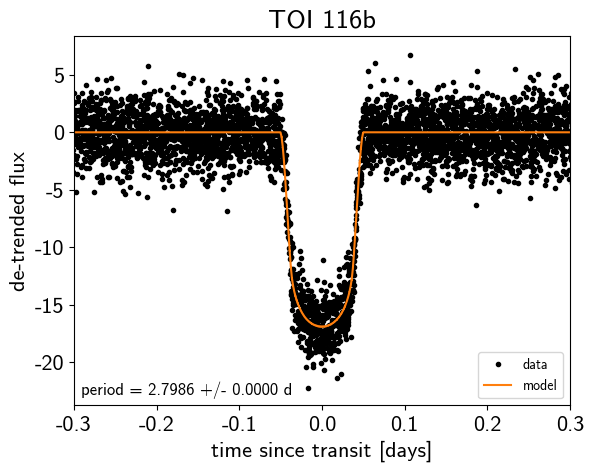

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

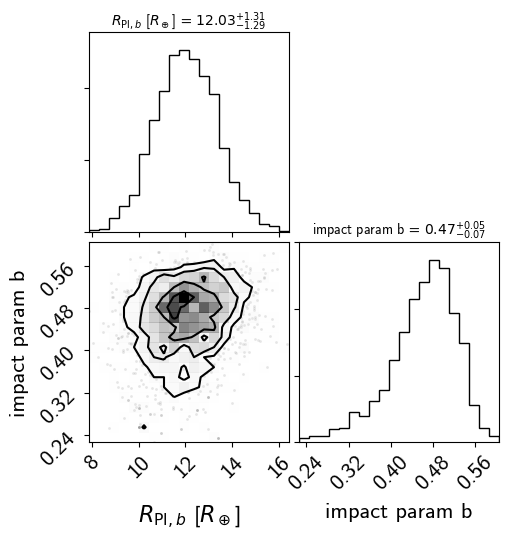

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

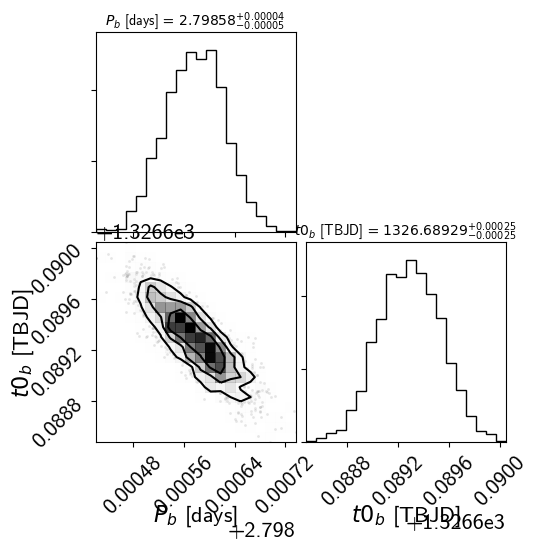

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

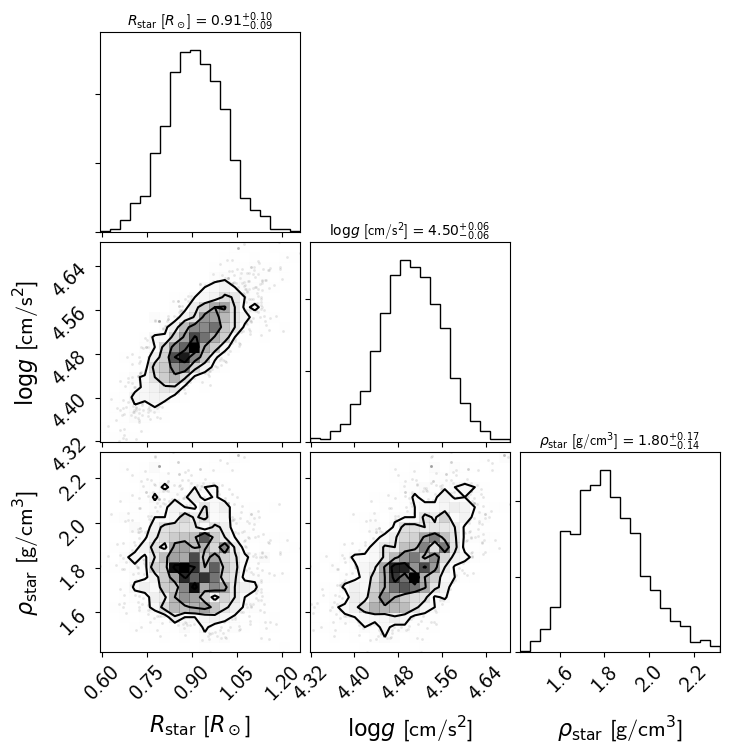

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3